In [ ]:
class Encoder(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.rnn = nn.RNN(1, hidden_size)

  def forward(self, inputs):
    outputs, hidden = self.rnn(inputs)

    return outputs, hidden

class Decoder(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.rnn = nn.RNN(1, hidden_size)
    self.out = nn.Linear(hidden_size, 1)

  def forward(self, initial_input, hidden, targets, teacher_force_probability):
    decoder_sequence_length = len(targets)

    outputs = [None for _ in range(decoder_sequence_length)]

    input_at_t = initial_input

    for t in range(decoder_sequence_length):
      output, hidden = self.rnn(input_at_t, hidden)
      outputs[t] = self.out(output)

      teacher_force = random.random() < teacher_force_probability
      input_at_t = targets[t] if teacher_force else outputs[t]

    return outputs

class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, lr):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.optimizer = torch.optim.Adam(self.parameters(), lr)
    self.criterion = nn.L1Loss()

  def forward(self, inputs, targets, teacher_force_probability):
    encoder_outputs, hidden = self.encoder(inputs)
    outputs = self.decoder(inputs[-1], hidden, targets, teacher_force_probability)

    return outputs

  def compute_loss(self, outputs, targets):
    return self.criterion(outputs, targets)

  def optimize(self, outputs, targets):
    self.optimizer.zero_grad()
    loss = self.compute_loss(outputs, targets)
    loss.backward()
    self.optimizer.step()


(24, 6)


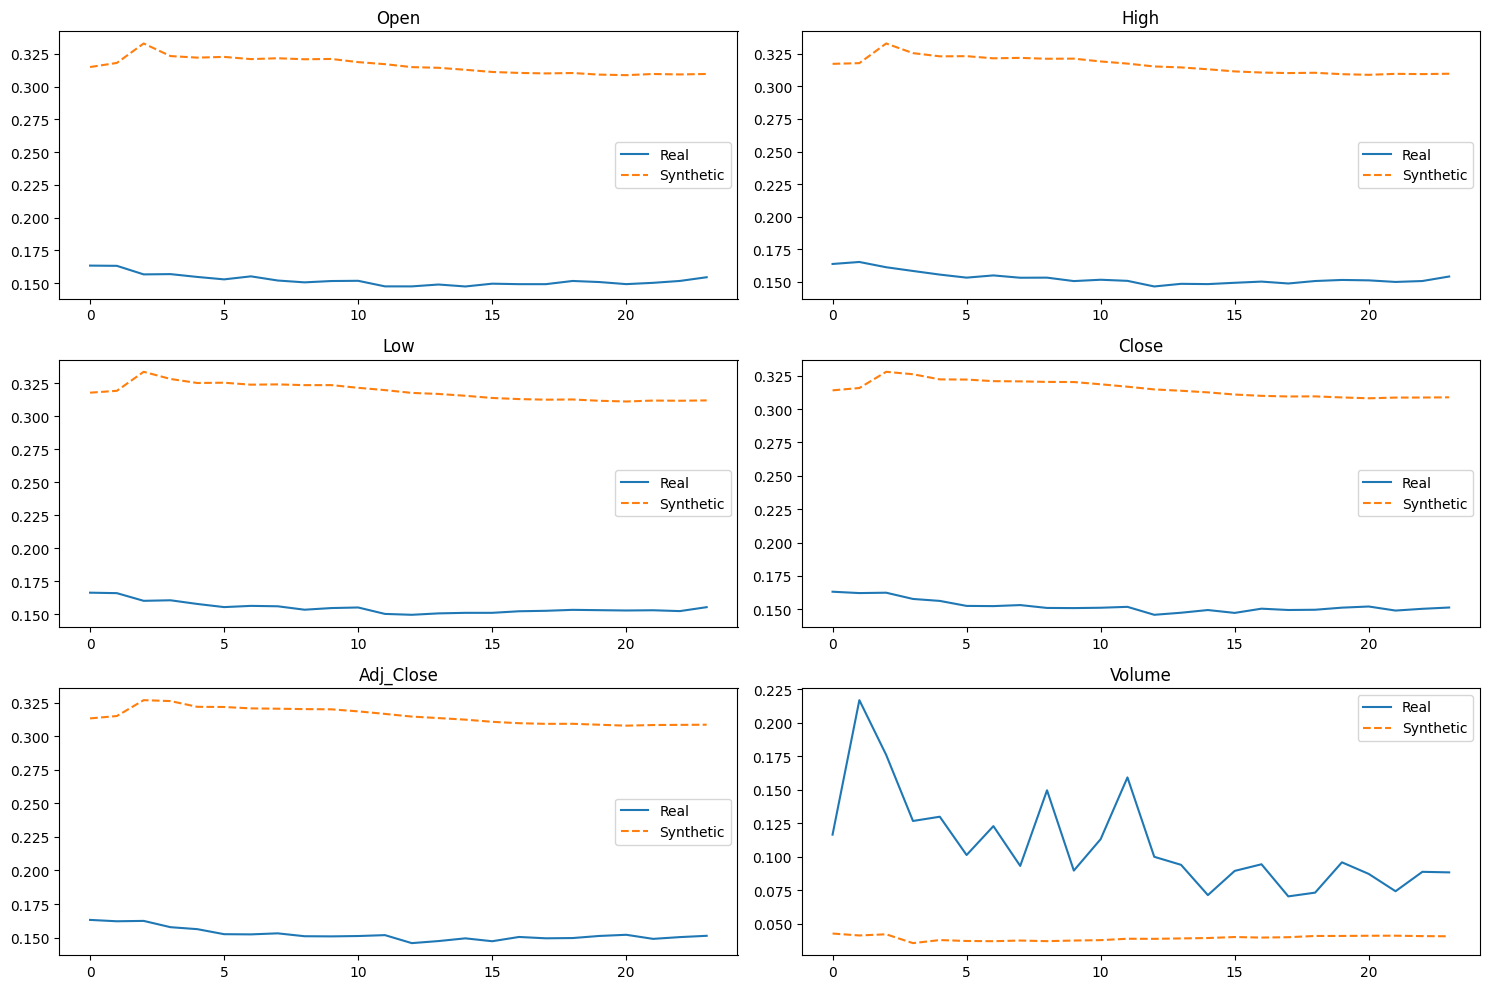

In [17]:
"""
    TimeGAN architecture example file
"""

# Importing necessary libraries
from os import path
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define model parameters
gan_args = ModelParameters(batch_size=128,
                           lr=5e-4,
                           noise_dim=32,
                           layers_dim=128,
                           latent_dim=24,
                           gamma=1)

train_args = TrainParameters(epochs=50000,
                             sequence_length=24,
                             number_sequences=6)

# Read the data
stock_data = pd.read_csv("dataset/stock_data.csv")
cols = list(stock_data.columns)

# Training the TimeGAN synthesizer
if path.exists('synthesizer_stock.pkl'):
    synth = TimeSeriesSynthesizer.load('synthesizer_stock.pkl')
else:
    synth = TimeSeriesSynthesizer(modelname='timegan', model_parameters=gan_args)
    synth.fit(stock_data, train_args, num_cols=cols)
    synth.save('synthesizer_stock.pkl')

# Generating new synthetic samples
stock_data_blocks = processed_stock(path='dataset/stock_data.csv', seq_len=24)
synth_data = synth.sample(n_samples=len(stock_data_blocks))
print(synth_data[0].shape)

# Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
# obs = np.random.randint(len(stock_data_blocks))
obs = 1

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data_blocks[obs][:, j],
                   'Synthetic': synth_data[obs].iloc[:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [23]:
stock_data_blocks[1][:, 5]

array([0.11662973, 0.21697265, 0.17614506, 0.12682304, 0.12999606,
       0.10141952, 0.12298544, 0.09328155, 0.1497181 , 0.08980041,
       0.1132658 , 0.15932417, 0.10009159, 0.09409958, 0.07151264,
       0.089566  , 0.09451765, 0.07056532, 0.07336135, 0.09598092,
       0.08732579, 0.07439929, 0.08888451, 0.08847006])

In [26]:
synth_data[1].iloc[:, 5]

0     0.042841
1     0.041406
2     0.042277
3     0.035685
4     0.037976
5     0.037283
6     0.037125
7     0.037615
8     0.037157
9     0.037613
10    0.037913
11    0.038949
12    0.038880
13    0.039203
14    0.039489
15    0.040230
16    0.039833
17    0.040104
18    0.041026
19    0.041042
20    0.041192
21    0.041223
22    0.040919
23    0.040788
Name: Volume, dtype: float32